## COVID Paper Exploration Workshop

### Part 1: Getting Paper Abstracts

In [51]:
import pandas as pd
import numpy as np
import datetime
import sys
import requests
import json
import time

In our example, we will only analyze a subset of paper abstracts. All paper metadata is available in **Metadata file** [Metadata.csv](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv). You need to:

1. Download [metadata.csv](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) file from Kaggle (you may need to log in / register first)
1. Place it in the current directory and unzip if needed.
1. Run the first few cells in the notebooks to get access to that data using Pandas.


In [5]:
df = pd.read_csv('metadata.csv')
df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


Now you can so some data cleanup: for example, convert publication time to datetime: 

In [6]:
df['publish_time'] = df['publish_time'].astype('datetime64')
df['abstract'] = df['abstract'].astype('str')

<AxesSubplot:>

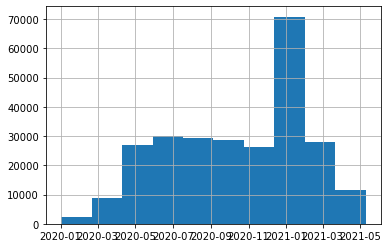

In [14]:
start_date = datetime.datetime(2020,1,1)
df = df[df['publish_time']>start_date]
df = df[df['publish_time']<datetime.datetime.now()]
df['publish_time'].hist()

### Part 2: Using Text Analytics for Health

In order to use [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=stud-27960-dmitryso), you need to obtain endpoint URL and a key. You need to create **Cognitive Services** resource in Azure Portal, and then obtain endpoint URL and access key from there.

> **Note:** Because it is a gated service, you also may need to obtain the access first.


In [29]:
endpoint = 'TODO: place URL here'
key = 'TODO: place key here'

Make sure the right version of SDK is installed:

In [27]:
!{sys.executable} -m pip install azure.ai.textanalytics==5.1.0b5

^C


Now, let's create an object to call the service:

In [30]:
from azure.core.credentials import AzureKeyCredential
from azure.ai.textanalytics import TextAnalyticsClient

text_analytics_client = TextAnalyticsClient(
    endpoint=endpoint, 
    credential=AzureKeyCredential(key),
    api_version="v3.1-preview.3")

Let's call the service and process first 5 abstracts. You can process up to 10 documents in a single call:

In [31]:
inp = [df['abstract'].iloc[i] for i in range(5)]
poller = text_analytics_client.begin_analyze_healthcare_entities([txt])
res = list(poller.result())
print(res)

[AnalyzeHealthcareEntitiesResultItem(id=0, entities=[HealthcareEntity(text=Dexmedetomidine, category=MedicationName, subcategory=None, length=15, offset=12, confidence_score=1.0, data_sources=[HealthcareEntityDataSource(entity_id=C0113293, name=UMLS), HealthcareEntityDataSource(entity_id=N05CM18, name=ATC), HealthcareEntityDataSource(entity_id=0000016239, name=CHV), HealthcareEntityDataSource(entity_id=DB00633, name=DRUGBANK), HealthcareEntityDataSource(entity_id=4219, name=GS), HealthcareEntityDataSource(entity_id=d04505, name=MMSL), HealthcareEntityDataSource(entity_id=D020927, name=MSH), HealthcareEntityDataSource(entity_id=67VB76HONO, name=MTHSPL), HealthcareEntityDataSource(entity_id=C47479, name=NCI), HealthcareEntityDataSource(entity_id=67VB76HONO, name=NCI_FDA), HealthcareEntityDataSource(entity_id=008084, name=NDDF), HealthcareEntityDataSource(entity_id=48937, name=RXNORM), HealthcareEntityDataSource(entity_id=437750002, name=SNOMEDCT_US), HealthcareEntityDataSource(entity_id=

In [34]:
for ri in res:
    for e in ri.entities:
        print(f'{e.text} ({e.category})')

Dexmedetomidine (MedicationName)
improve (ConditionQualifier)
organ dysfunction (Diagnosis)
ill (Diagnosis)
randomized controlled trial (AdministrativeEvent)
Dexmedetomidine (MedicationName)
Sepsis (Diagnosis)
Intensive Care Unit (CareEnvironment)
ICU (CareEnvironment)
dexmedetomidine (MedicationName)
reduced mortality risk (SymptomOrSign)
severe (ConditionQualifier)
sepsis (Diagnosis)
improved survival (SymptomOrSign)
sedated (TreatmentName)
dexmedetomidine (MedicationName)
sedation strategy (TreatmentName)
dexmedetomidine (MedicationName)
mechanically ventilated (TreatmentName)
adult (Age)
sepsis (Diagnosis)
ICUs (CareEnvironment)
Acute Physiology and Chronic Health Evaluation II (ExaminationName)
APACHE II (ExaminationName)
≥ (RelationalOperator)
23 (MeasurementValue)
54 (MeasurementValue)
dexmedetomidine (MedicationName)
DEX (MedicationName)
50 (MeasurementValue)
dexmedetomidine (MedicationName)
-DEX (MedicationName)
sequential organ failure assessment (ExaminationName)
SOFA (Exami

**TASK**: Run Text Analytics for Health through 100 random abstracts and explore the results:
 
1. See which medications are mentioned most often
1. Build the word cloud of medications and diagnoses (use [this tutorial](https://www.datacamp.com/community/tutorials/wordcloud-python) as a guideline)

## Using REST API to get JSON data

In addition to using Python SDK, you can also call Text Analytics using REST API directly. This is useful if you are using a programming language that does not have a corresponding SDK, or if you prefer to receive Text Analytics result in the JSON format for further storage or processing.

In [54]:
inp = [ { "id" : df['cord_uid'].iloc[i] , "text" : df['abstract'].iloc[i] } for i in range(5) ]

def analyze(doc):
    uri = f"{endpoint}/text/analytics/v3.1-preview.3/entities/health/jobs?model-version=v3.1-preview.4"
    headers = { "Ocp-Apim-Subscription-Key" : key }
    resp = requests.post(uri,headers=headers,json={ "documents" : doc })
    if resp.status_code!=202:
        print(f"Error: submission, {resp}")
        return None
    url = resp.headers['operation-location']
    for _ in range(80):
        time.sleep(1)
        resp = requests.get(url,headers=headers)
        t = resp.json()
        if t['status'] == 'succeeded':
            return t['results']
    print("Error: timeout")
    return None

res = analyze(inp)

In [61]:
res['documents'][0]['entities'][0]

{'offset': 12,
 'length': 15,
 'text': 'Dexmedetomidine',
 'category': 'MedicationName',
 'confidenceScore': 1.0,
 'isNegated': False,
 'links': [{'dataSource': 'UMLS', 'id': 'C0113293'},
  {'dataSource': 'ATC', 'id': 'N05CM18'},
  {'dataSource': 'CHV', 'id': '0000016239'},
  {'dataSource': 'DRUGBANK', 'id': 'DB00633'},
  {'dataSource': 'GS', 'id': '4219'},
  {'dataSource': 'MMSL', 'id': 'd04505'},
  {'dataSource': 'MSH', 'id': 'D020927'},
  {'dataSource': 'MTHSPL', 'id': '67VB76HONO'},
  {'dataSource': 'NCI', 'id': 'C47479'},
  {'dataSource': 'NCI_FDA', 'id': '67VB76HONO'},
  {'dataSource': 'NDDF', 'id': '008084'},
  {'dataSource': 'RXNORM', 'id': '48937'},
  {'dataSource': 'SNOMEDCT_US', 'id': '437750002'},
  {'dataSource': 'VANDF', 'id': '4021214'}]}

**TASK**: Write a code to analyze 200 random abstracts, and store the result in JSON format for further processing. You may want to store the results in files, or just in memory as Python dicts.

**Note**: In the next section, we will store the result into the database. If you feel confident, you may go trough the next section, and write the combined code to process the abstracts and store the results into the database at the same time.

## Using CosmosDB to Store Analysis Result

It makes sense to store the result of processing in NoSQL database, because inherently the are designed to store and query large collections of JSON documents. We will use Cosmos DB to do this:

1. [Create Cosmos DB database](https://docs.microsoft.com/azure/cosmos-db/create-cosmosdb-resources-portal/?WT.mc_id=stud-27960-dmitryso) on Azure Portal
1. Note the endpoint URL and key
1. Create a collection

In [65]:
import azure.cosmos

cosmos_uri = 'https://<TODO: database name here>.documents.azure.com:443/'
cosmos_key = 'TODO: Insert key here'
database_name = "TODO"
container_name = "TODO"

Now we will take the results from previous step and insert them into the database:

In [66]:
coscli = azure.cosmos.CosmosClient(cosmos_uri, credential=cosmos_key)
cosdb = coscli.get_database_client(database_name)
cospapers = cosdb.get_container_client(container_name)
for x in res['documents']:
    cospapers.upsert_item(x)

You can now go to Azure Portal, and see the inserted items in the **Data Explorer**

**TASK**: Store the result of processing of 200 random abstracts obtained during the step above into the database.

## Querying data

Now you can write SQL Queries to Cosmos DB in the Query Explorer on Azure Portal. Syntax for queries can be found [in this document](https://docs.microsoft.com/azure/cosmos-db/sql-query-getting-started/?WT.mc_id=stud-27960-dmitryso). For example, here is how we can obtain the list of all medications found in the corpus:
```sql
-- unique medication names
SELECT DISTINCT e.text 
FROM papers p 
JOIN e IN p.entities 
WHERE e.category='MedicationName'
```

**TASK**: Write queries to do the following:

1. Obtain the data for word cloud for medications (the result should include medication name and number of mentions) and diagnoses
1. Obtain different dosage of hydroxychloroquine mentioned in papers, together with paper and author names


## (Optional) Plot Co-Occurence Diagrams

Using the JSON data above, you can plot the relation diagrams between different terms, similar to the ones below:

![](http://soshnikov.com/images/blog/paperan/sankey-diag-med.png)

To visualize such dependencies, there are two types of diagrams:
* **Sankey diagram** allows us to investigate relations between two types of terms, eg. diagnosis and treatment.
* **Chord diagram** helps to visualize co-occurrence of terms of the same type (eg. which medications are mentioned together)

![Medications](http://soshnikov.com/images/blog/paperan/cooccur-med.png)

To plot both diagrams, we need to compute **co-occurrence matrix**, which in the row `i` and column `j` contains number of co-occurrences of terms `i` and `j` in the same abstract (one can notice that this matrix is symmetric). 
To plot the Sankey diagram, we can use [Plotly](https://plotly.com/python/) graphics library. This process is well described [here](https://plotly.com/python/sankey-diagram/). Plotting Chord diagram can be done using [Chord](https://pypi.org/project/chord/) Python library.



## Exploring Data from withing Cosmos DB

In the example above, we could either query data in Cosmos DB, or do the processing in Python. It would be nice to be able to do some Python processing on top of the query result. The most convenient way to do it is to use **Notebooks embedded into Cosmos DB**. Please, proceed with the instructions on the [Workshop page](http://github.com/CloudAdvocacy/AzurePaperExplorationWorkshop) to explore this further.
